## Merge images

In [ ]:
import datasets
import numpy as np
from PIL import Image
import random
from collections import defaultdict


def create_object_counting_dataset(
    original_ds: datasets.DatasetDict,
    shape: tuple[int, int],
    n_per_class: int = 1,
) -> datasets.DatasetDict:
  """
  Create an object counting dataset by merging Fashion-MNIST images into grids.

  Args:
      original_ds: The original Fashion-MNIST dataset
      shape: (rows, cols) - grid dimensions
      n_per_class: Number of images to select per class for each sample
      n: Number of samples to create per split

  Returns:
      New dataset with merged images and label matrices
  """
  area = shape[0] * shape[1]
  if not area % n_per_class == 0:
    raise ValueError(f"Grid area {area} must be divisible by n_per_class {n_per_class}")
  
  def merge_within_split(split_data):
    class_to_images = defaultdict(list)
    for item in split_data:
      class_to_images[item['label']].append((item['image']))
    for k in class_to_images:
      random.shuffle(class_to_images[k])
    merged_ds = {'image': [], 'label_matrix': []}
    while len(class_to_images) >= area // n_per_class:
      selected_classes = random.sample(class_to_images.keys(), min(len(class_to_images), area // n_per_class))
      selected_images = []
      for label in selected_classes:
        for _ in range(n_per_class):
          selected_images.append((class_to_images[label].pop(), label))
        if not class_to_images[label]:
          class_to_images.pop(label)
      random.shuffle(selected_images)
      merged_image = Image.new('L', (28 * shape[1], 28 * shape[0]))
      label_matrix = np.zeros((shape[0], shape[1]), dtype=int)
      for idx, (img, label) in enumerate(selected_images):
        row = idx // shape[1]
        col = idx % shape[1]
        merged_image.paste(img, (col * 28, row * 28))
        label_matrix[row, col] = label
      merged_ds['image'].append(merged_image)
      merged_ds['label_matrix'].append(label_matrix)
    return merged_ds
  
  new_splits = {}
  for split_name, split_data in original_ds.items():
    samples = merge_within_split(split_data)
    new_splits[split_name] = datasets.Dataset.from_dict(samples)

  return datasets.DatasetDict(new_splits)


# Load the original dataset
ds = datasets.load_dataset("zalando-datasets/fashion_mnist")

# Create the object counting dataset
counting_ds = create_object_counting_dataset(
    original_ds=ds,
    shape=(2, 2),
    n_per_class=1
)

In [ ]:
from tqdm import tqdm

vert_coord = ['top', 'bottom']
hori_coord = ['left', 'right']
ds_w_questions = defaultdict(list)
for split_name, split_data in counting_ds.items():
  for item in tqdm(split_data):
    for v, h in [(0, 0), (0, 1), (1, 0), (1, 1)]:
      ds_w_questions[split_name].append({
        'image': item['image'],
        'question': f'What type of clothing is in the {vert_coord[v]}-{hori_coord[h]} corner?',
        'answer': item['label_matrix'][v][h],
        'coord': (v, h)
      })
ds_w_questions = datasets.DatasetDict({
    split: datasets.Dataset.from_list(data) for split, data in ds_w_questions.items()
})

In [ ]:
label_to_str = [
  "0. T-shirt/top",
  "1. Trouser",
  "2. Pullover",
  "3. Dress",
  "4. Coat",
  "5. Sandal",
  "6. Shirt",
  "7. Sneaker",
  "8. Bag",
  "9. Ankle boot",
]

def convert_class_label_to_string(item):
  item['answer'] = label_to_str[item['label']]
  return item

ds_w_questions = (
  ds_w_questions
  .rename_columns({'answer': 'label'})
  .map(convert_class_label_to_string, num_proc=32)
)

In [ ]:
ds_w_questions.push_to_hub("withcomment/merged_fashion", private=True)

In [ ]:

# Display dataset info
print("Original dataset features:", ds['train'].features)
print("New dataset features:", counting_ds['train'].features)
print("New dataset splits:", counting_ds.keys())
for split_name, split_data in counting_ds.items():
  print(f"{split_name}: {len(split_data)} samples")

# Example: visualize a sample
sample = counting_ds['train'][14981]
print("Sample label matrix:")
print(np.array(sample['label_matrix']))
sample['image']

## Experiments

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/projects/cft_vlm/finetune')

In [ ]:
import transformers
import torch
from copy import deepcopy
model_0 = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda:1",
    attn_implementation="eager",
)
model_1 = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
  "/projects/cft_vlm/.checkpoint/Qwen2.5-VL-3B-Instruct-merged_fashion_sys_default_usr_fashion_mnist/checkpoint-26",
  torch_dtype=torch.bfloat16,
  device_map="cuda:2",
  attn_implementation="eager",
)
model_2 = transformers.Qwen2_5_VLForConditionalGeneration.from_pretrained(
  "/projects/cft_vlm/.checkpoint/Qwen2.5-VL-3B-Instruct-merged_fashion_sys_default_usr_fashion_mnist",
  torch_dtype=torch.bfloat16,
  device_map="cuda:3",
  attn_implementation="eager",
)

processor = transformers.AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", use_fast=True)
processor.image_processor.size = (224, 224)
gen_config = deepcopy(model_0.generation_config)
gen_config.max_new_tokens = 1
gen_config.do_sample = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


: 

In [2]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np

from qwenvl.data.input_processor import VISION_END, VISION_START
from qwenvl.module import create_module, create_strategies
from qwenvl.argument import DataArguments, ProcessingArguments
from qwenvl.train import set_processor
from qwenvl.data.prompts import *

data_args = DataArguments(
    dataset_use='merged_fashion',
    split='test',
    packing=False,
    model_max_length=512,)

proc_args = ProcessingArguments(
    use_chat_template=True,
    sys_prompt="default",
    usr_prompt='fashion_mnist,number_only',
    add_generation_prompt=True,
    use_bf16=True,
    image_min_pixels=224 * 224,
)
processor = set_processor(processor, proc_args, data_args)
processor.image_processor.do_resize = True
strategies, cp, ip = create_strategies(processor, data_args, proc_args, rank=0)
ds, collate = create_module(data_args, strategies, cp, ip)


NameError: name 'processor' is not defined

In [ ]:
import random

transformers.logging.set_verbosity_error()

shuffled_map = [
  "1. Trouser",
  "9. Ankle boot",
  "7. Sneaker",
  "2. Pullover",
  "6. Shirt",
  "8. Bag",
  "5. Sandal",
  "0. T-shirt/top",
  "4. Coat",
  "3. Dress",
]

vs_id = processor.tokenizer.convert_tokens_to_ids(VISION_START)
ve_id = processor.tokenizer.convert_tokens_to_ids(VISION_END)
sample_images = random.sample(range(len(ds) // 4), 100)
sample = [i + idx * 4 for idx in sample_images for i in range(4)]

def generate_and_extract_attentions(model, sample):
  attns = []
  samples = []

  with torch.no_grad():
    for idx in tqdm(sample):
      item = ds[idx]
      inputs = collate(item).to(model.device)
      output = model.generate(**inputs, return_dict_in_generate=True,
                          output_attentions=True, generation_config=gen_config)
      attn = [[] for _ in range(len(output.attentions[0]))]
      for token_idx, token_attn in enumerate(output.attentions):
        for layer_idx, layer_attn in enumerate(token_attn):
          layer_attn = layer_attn.squeeze()
          attn[layer_idx].append(layer_attn)

      for layer_idx, layer_attn in enumerate(attn):
    # Cat along query dimension
        attn[layer_idx] = torch.cat(layer_attn, dim=1)
    
      attns.append(torch.stack(attn, dim=0).detach().cpu())
      generated_ids = output.sequences[0][-1:]
      item = deepcopy(item[0])
      item['model_answer'] = ip.tokenizer.convert_ids_to_tokens(generated_ids)
      try:
        item['model_answer'] = shuffled_map[int(item['model_answer'][0])][0]
      except ValueError:
        item['model_answer'] = item['model_answer'][0]
      item['combined_ids'] = output.sequences[0]
      samples.append(item)

  # attns.shape = (n_sample, layers, heads, q_len, k_len)
  attns = torch.stack(attns, dim=0).squeeze()
  return attns, samples


def get_is_correct(samples):
  return torch.tensor([sample['model_answer'][0] == sample['answer'][0] for sample in samples], dtype=torch.float32)

attns_0, samples_0 = generate_and_extract_attentions(model_0, sample)
attns_1, samples_1 = generate_and_extract_attentions(model_1, sample)
attns_2, samples_2 = generate_and_extract_attentions(model_2, sample)

is_correct_0 = get_is_correct(samples_0)
is_correct_1 = get_is_correct(samples_1)
is_correct_2 = get_is_correct(samples_2)
print(is_correct_0.mean(), is_correct_1.mean(), is_correct_2.mean())
print(is_correct_0.reshape(-1, 4).mean(dim=0))
print(is_correct_1.reshape(-1, 4).mean(dim=0))
print(is_correct_2.reshape(-1, 4).mean(dim=0))

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:00<00:00,  6.61it/s]


tensor(0.4525) tensor(0.7025) tensor(0.7000)
tensor([0.5600, 0.2400, 0.5100, 0.5000])
tensor([0.7200, 0.6600, 0.7000, 0.7300])
tensor([0.7200, 0.6600, 0.6700, 0.7500])


: 

In [ ]:
def group_vision_attns(attns, quadrant_width_n_tokens=4):
  '''Reshape the last dimension into quadrants.'''
  avg_vision_attn = attns.reshape(*attns.shape[:-1], 2 * quadrant_width_n_tokens, 2 * quadrant_width_n_tokens)
  grouped_attn = torch.zeros(*avg_vision_attn.shape[:-2], 4, quadrant_width_n_tokens, quadrant_width_n_tokens)
  grouped_attn[..., 0, :, :] = avg_vision_attn[..., 0:quadrant_width_n_tokens, 0:quadrant_width_n_tokens]  # top-left
  grouped_attn[..., 1, :, :] = avg_vision_attn[..., 0:quadrant_width_n_tokens, quadrant_width_n_tokens:]  # top-right
  grouped_attn[..., 2, :, :] = avg_vision_attn[..., quadrant_width_n_tokens:, 0:quadrant_width_n_tokens]  # bottom-left
  grouped_attn[..., 3, :, :] = avg_vision_attn[..., quadrant_width_n_tokens:, quadrant_width_n_tokens:]  # bottom-right
  return grouped_attn

: 

tensor([[0.0007, 0.0004, 0.0004, 0.0003],
        [0.0005, 0.0006, 0.0004, 0.0004],
        [0.0004, 0.0004, 0.0006, 0.0003],
        ...,
        [0.0005, 0.0004, 0.0003, 0.0003],
        [0.0005, 0.0002, 0.0004, 0.0002],
        [0.0005, 0.0002, 0.0003, 0.0003]])

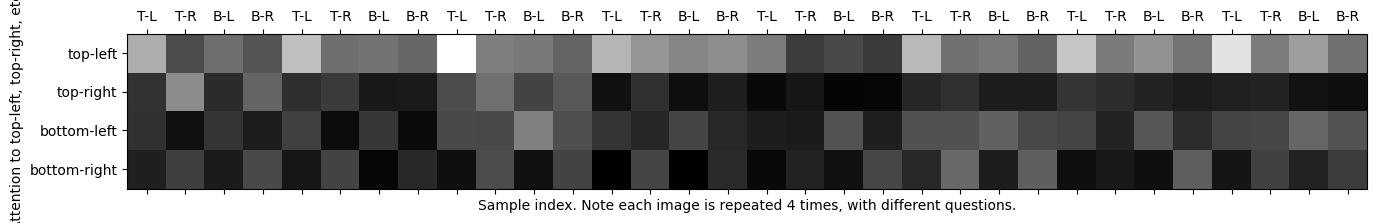

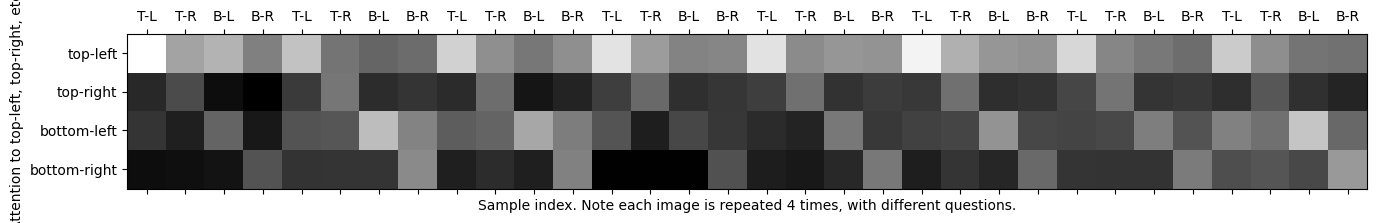

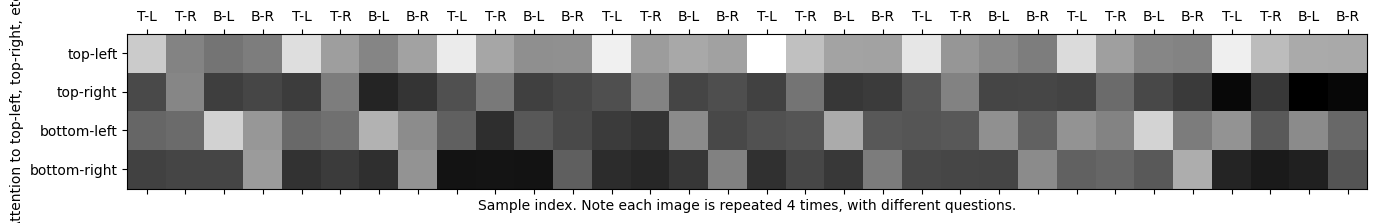

: 

In [ ]:
def plot_attn(attns, quadrant_width_n_tokens=4):
  grouped_attn = group_vision_attns(attns[..., -1, 15:79], quadrant_width_n_tokens)
  avg_vision_attn = grouped_attn.mean(dim=(1, 2, -1, -2)).to(torch.float32)
  fig, axes = plt.subplots(1, 1, figsize=(16, 5))
  avg_vision_attn_lr = avg_vision_attn.squeeze().numpy()
  selected_idx = random.randint(0, 90) * 4
  n_samples = 32
  avg_vision_attn_lr = avg_vision_attn_lr[selected_idx:selected_idx + n_samples]
  axes.matshow(avg_vision_attn_lr.T, cmap='gray')
  axes.set_xlabel('Sample index. Note each image is repeated 4 times, with different questions.')
  axes.set_ylabel('Attention to top-left, top-right, etc')
  axes.set_xticks(range(n_samples), ['T-L', 'T-R', 'B-L', 'B-R'] * (n_samples // 4))
  axes.set_yticks(range(4), ['top-left', 'top-right', 'bottom-left', 'bottom-right'])
  fig.show()
  return avg_vision_attn

plot_attn(attns_0)
plot_attn(attns_1)
plot_attn(attns_2)

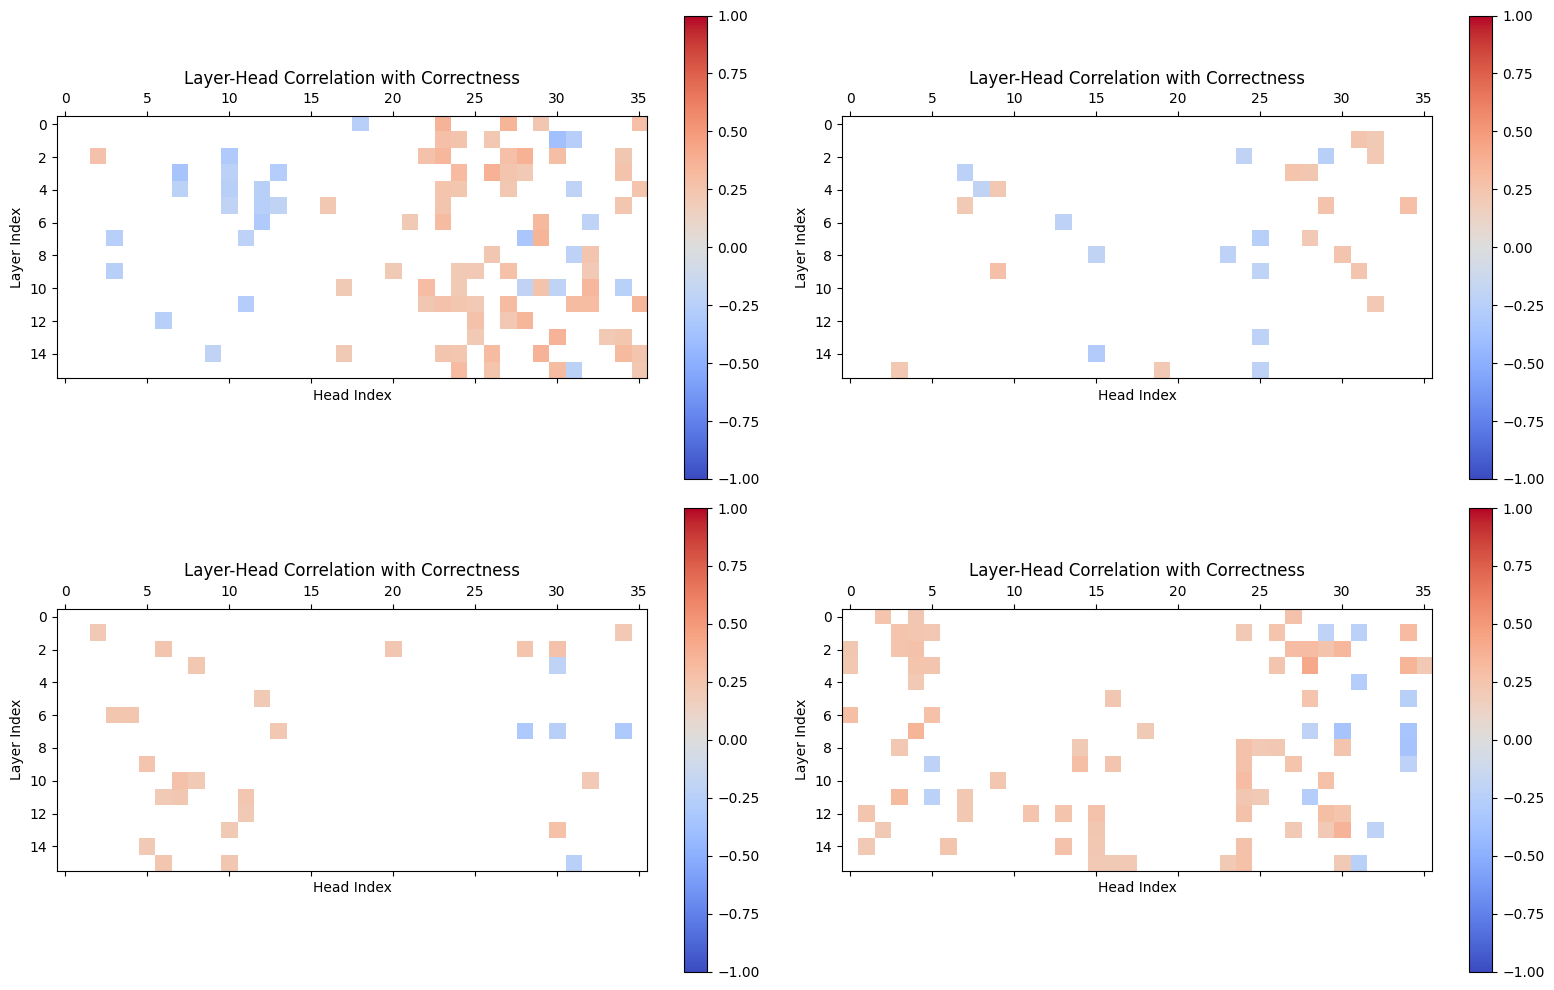

In [8]:
from matplotlib import colormaps as cm

def layer_head_correlation(attns: torch.Tensor, is_correct, corr_fn, ax):

  if corr_fn == spearmanr:
    corr, pvals = [], []
    for layer_idx in range(attns.shape[0]):
      for head_idx in range(attns.shape[1]):
        result = spearmanr(is_correct, attns[layer_idx, head_idx])
        corr.append(result.statistic)
        pvals.append(result.pvalue)
    corr = np.array(corr).reshape(attns.shape[0], attns.shape[1])
    pvals = np.array(pvals).reshape(attns.shape[0], attns.shape[1])
  else:
    result = pearsonr(is_correct, attns, axis=-1)
    corr = result.statistic
    pvals = result.pvalue
    
  corr[pvals > 0.05] = np.nan  # Mask out non-significant correlations

  coolwarm = cm['coolwarm'].copy()
  coolwarm.set_bad('lightgray')
  cb = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
  ax.set_title('Layer-Head Correlation with Correctness')
  ax.set_xlabel('Head Index')
  ax.set_ylabel('Layer Index')
  return cb
  
def layer_head_correlation_by_qtype(attns, is_correct, corr_fn):
  attns = attns.reshape(-1, 4, *attns.shape[1:]).transpose(0, 1)
  avg_attn = attns[..., -1, 15:79].to(torch.float32).mean(dim=-1)
  avg_attn = avg_attn.transpose(1, -1)
  is_correct = is_correct.reshape(-1, 4).T
  fig, axes = plt.subplots(2, 2, figsize=(16, 10))
  for (idx, (qtype, ax)) in enumerate(zip(['top-left', 'top-right', 'bottom-left', 'bottom-right'], axes.flat)):
    ax.set_title(f'Attention for {qtype} question')
    cb = layer_head_correlation(avg_attn[idx], is_correct[idx], corr_fn, ax)
    fig.colorbar(cb, ax=ax)
  
  fig.tight_layout()
  fig.show()
  

layer_head_correlation_by_qtype(attns_0, is_correct_0, pearsonr)
# layer_head_correlation_by_qtype(attns_1, is_correct_1, pearsonr)
# layer_head_correlation_by_qtype(attns_2, is_correct_2, pearsonr)

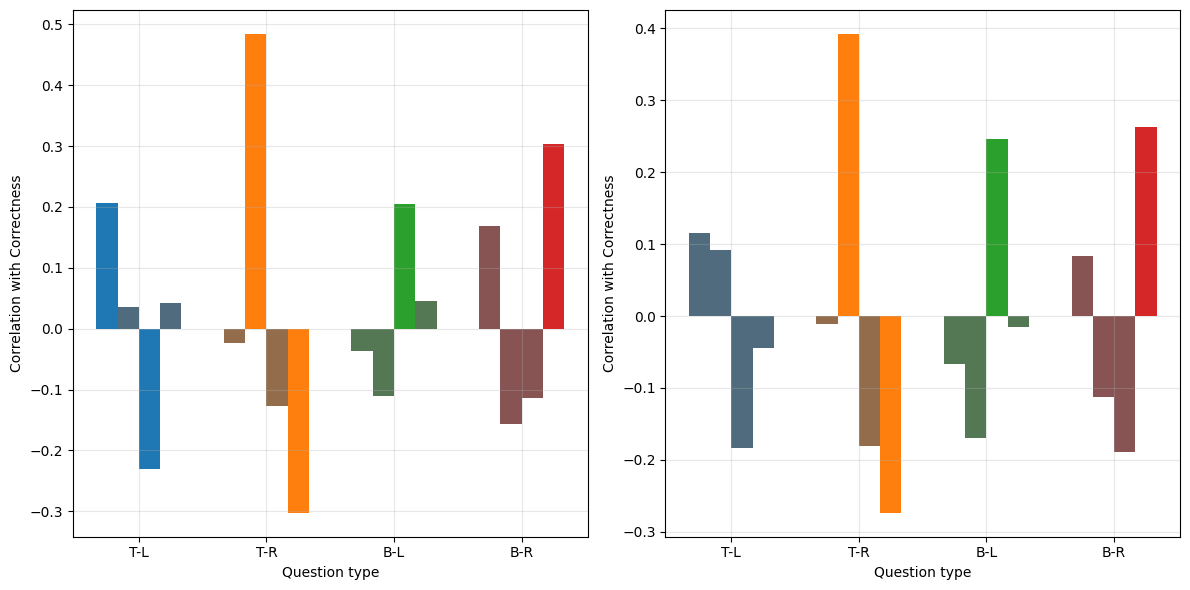

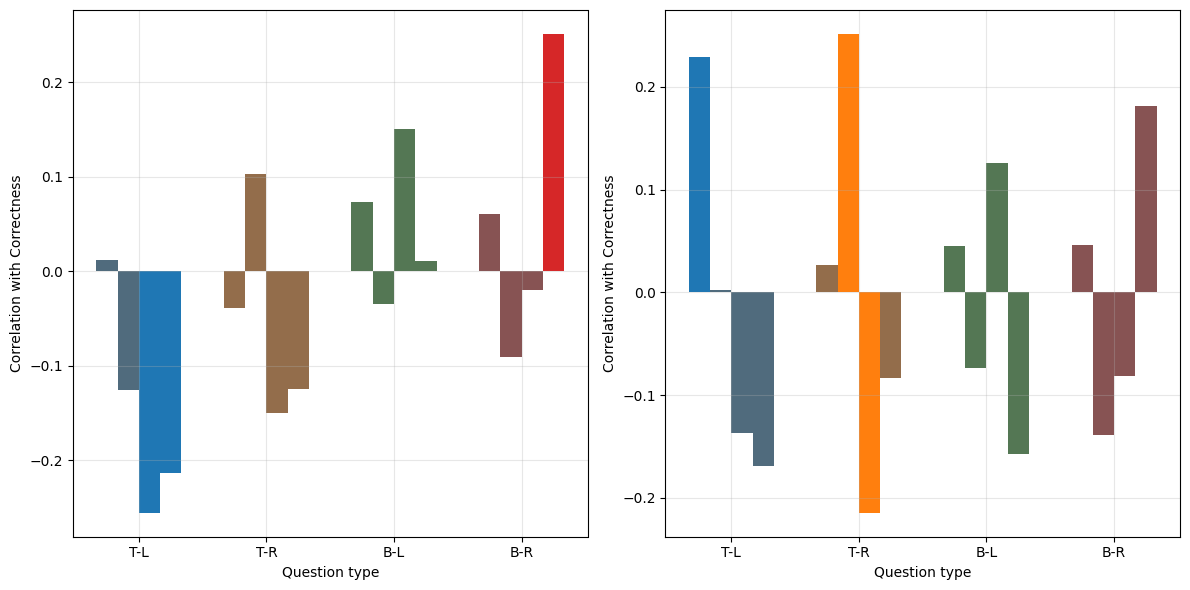

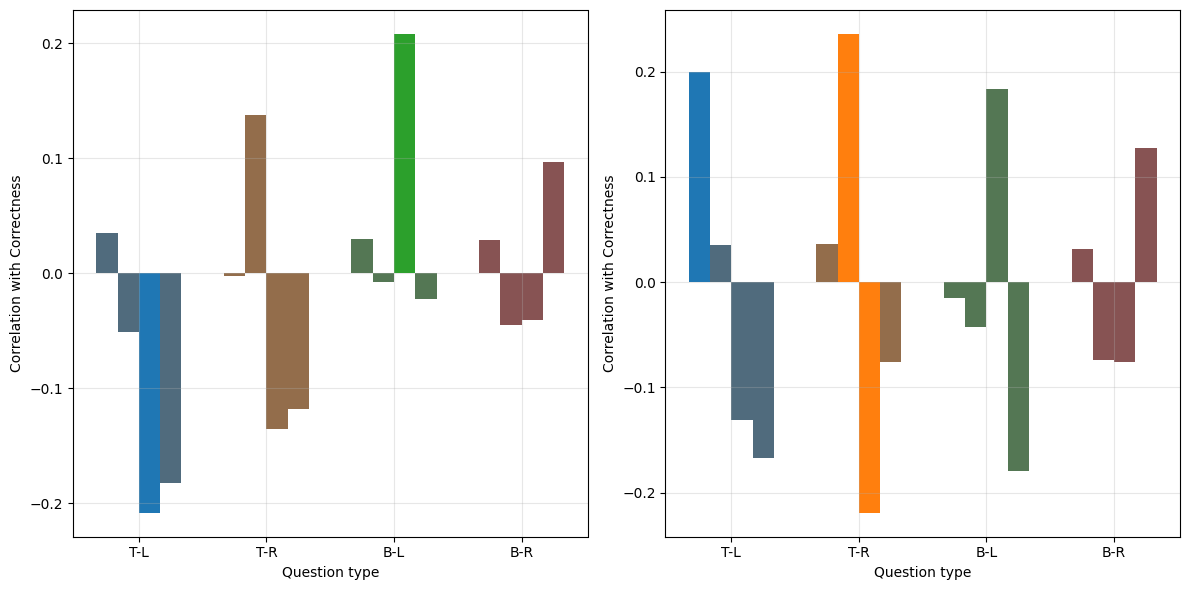

: 

In [ ]:
def key_token_correlation(attns, is_correct, corr_fn, ax=None, index=0, label=None):
  if ax is None:
    ax = plt

  attns = attns.mean(dim=(1, 2))
  is_correct = is_correct.view(-1, 1)
  
  result = corr_fn(is_correct, attns, axis=0)
  
  insig_idx = result.pvalue >= 0.05
  
  # Get color from matplotlib default cycle
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']
  base_color = colors[index % len(colors)]
  
  x_offset = index * 1.2 + np.arange(4) * 0.2
  ax.bar(x_offset, result.statistic, color=base_color, width=0.2)
  gray_tinted = (0.4, 0.4, 0.4, 0.7)
  ax.bar(x_offset[insig_idx], result.statistic[insig_idx], color=gray_tinted, width=0.2)
  group_centers = np.arange(4) * 1.2 + 0.3
  ax.set_xticks(group_centers)
  ax.set_xticklabels(['T-L', 'T-R', 'B-L', 'B-R'])
  ax.set_xlabel('Question type')
  ax.set_ylabel('Correlation with Correctness')
  ax.grid(True, alpha=0.3)

def plot_token_acc_correlation(attns, is_correct):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  attns = attns.reshape(-1, 4, *attns_0.shape[1:]).transpose(1, 0)
  attns = group_vision_attns(attns[..., -1, 15:79], quadrant_width_n_tokens=4).to(torch.float32).mean(dim=(-1, -2))
  norm_attns = attns / attns.sum(dim=-1, keepdim=True)
  is_correct = is_correct.reshape(-1, 4).transpose(1, 0)
  
  coord_labels = ['T-L Question', 'T-R Question', 'B-L Question', 'B-R Question']

  for i in range(4):
    key_token_correlation(attns[i], is_correct[i], corr_fn=pearsonr, ax=axes[0], index=i)
    key_token_correlation(norm_attns[i], is_correct[i], corr_fn=pearsonr, ax=axes[1], index=i)


  fig.tight_layout()
  fig.show()

plot_token_acc_correlation(attns_0, is_correct_0)
plot_token_acc_correlation(attns_1, is_correct_1)
plot_token_acc_correlation(attns_2, is_correct_2)

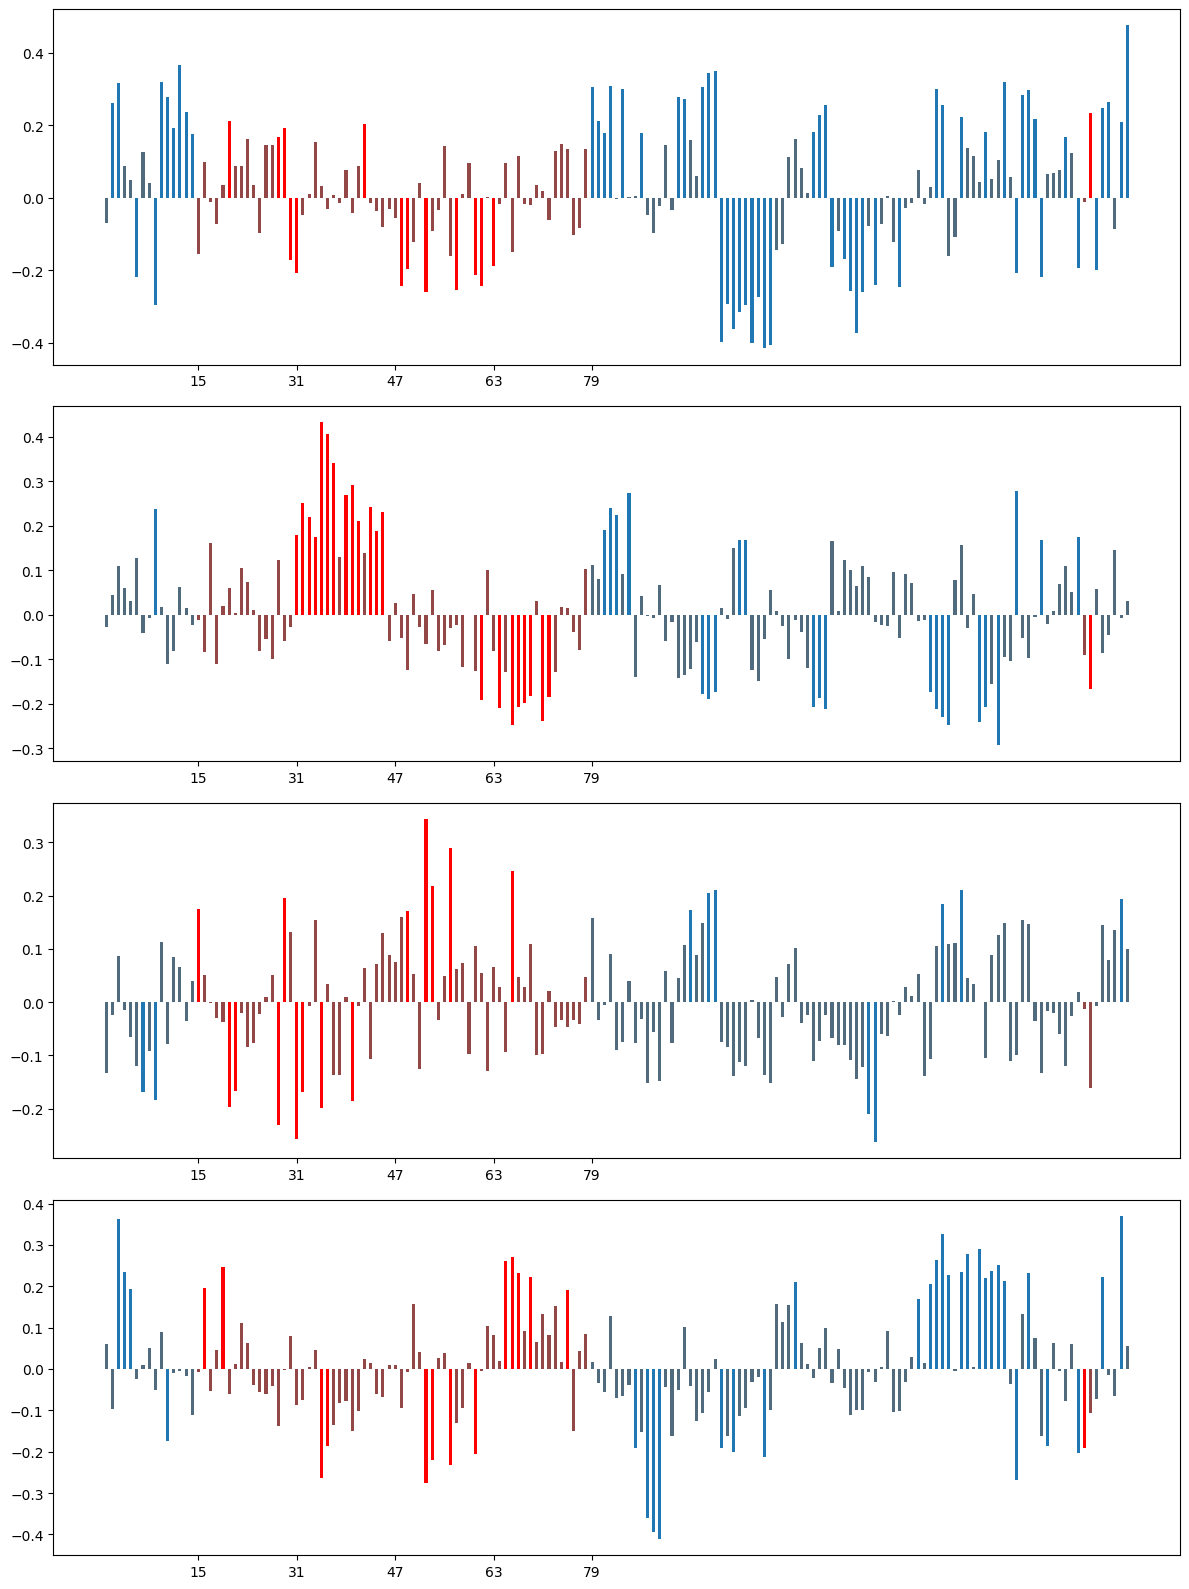

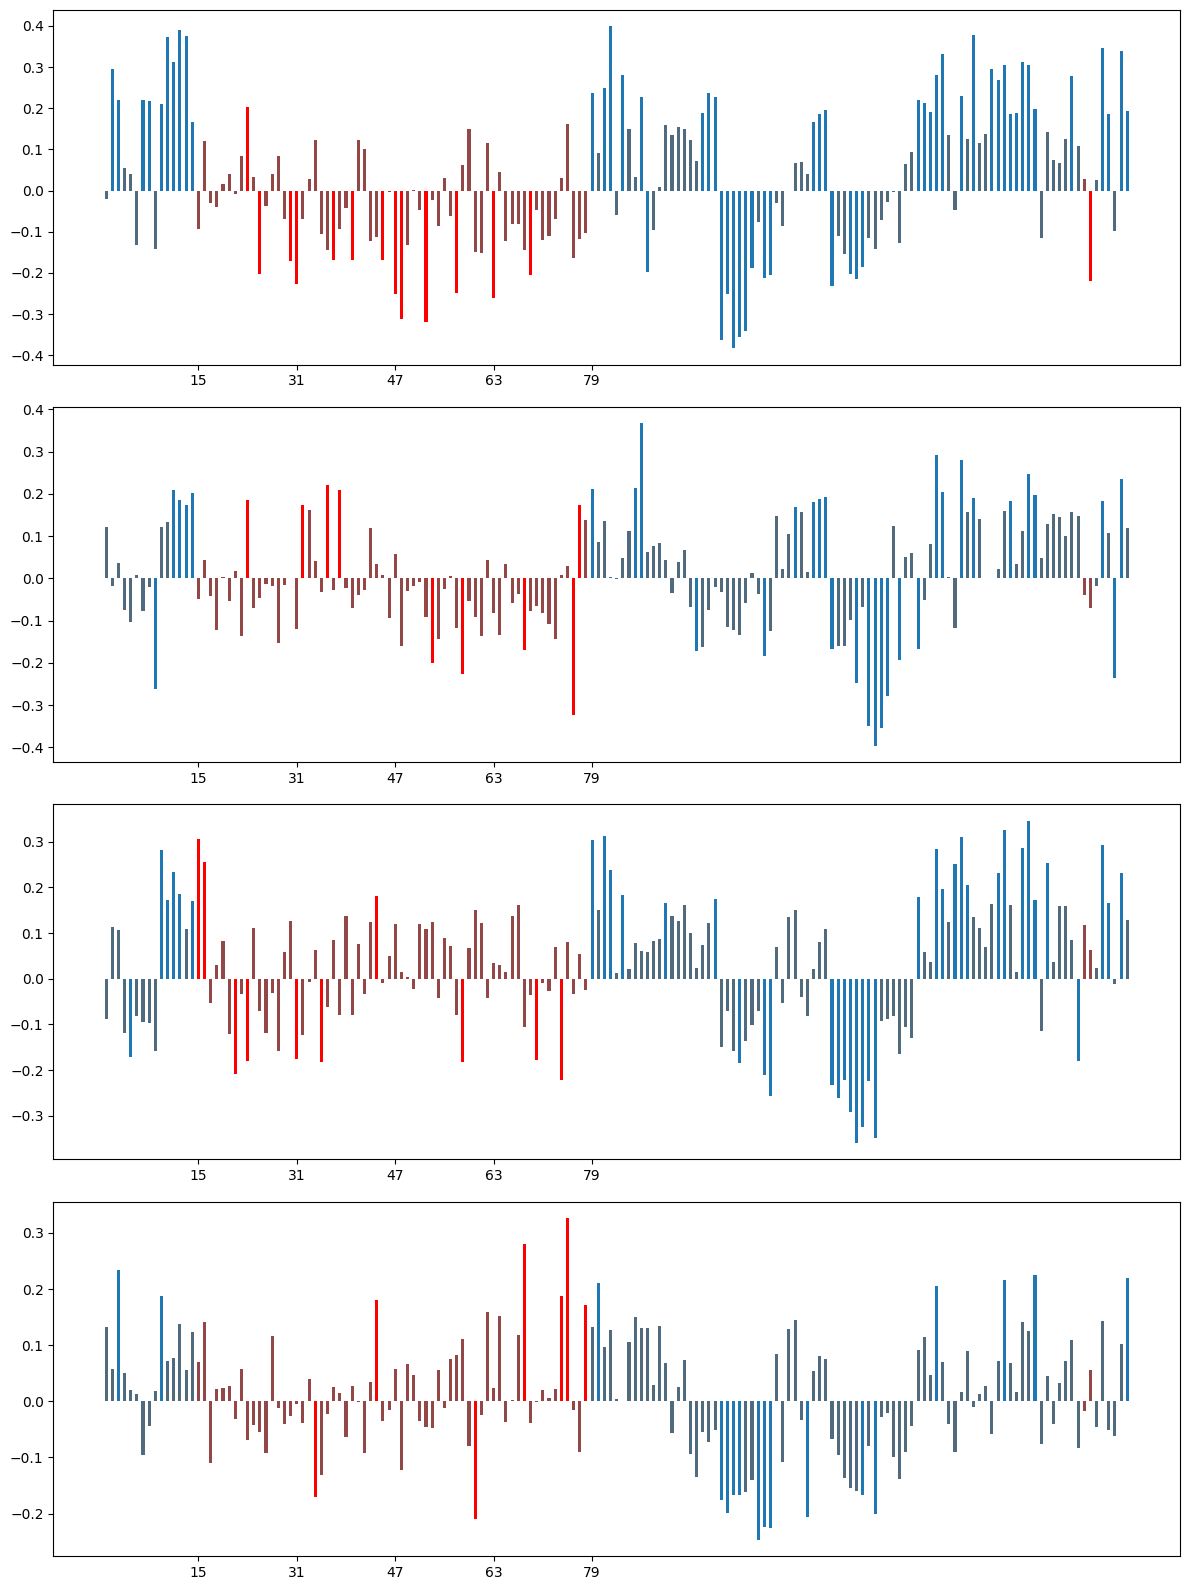

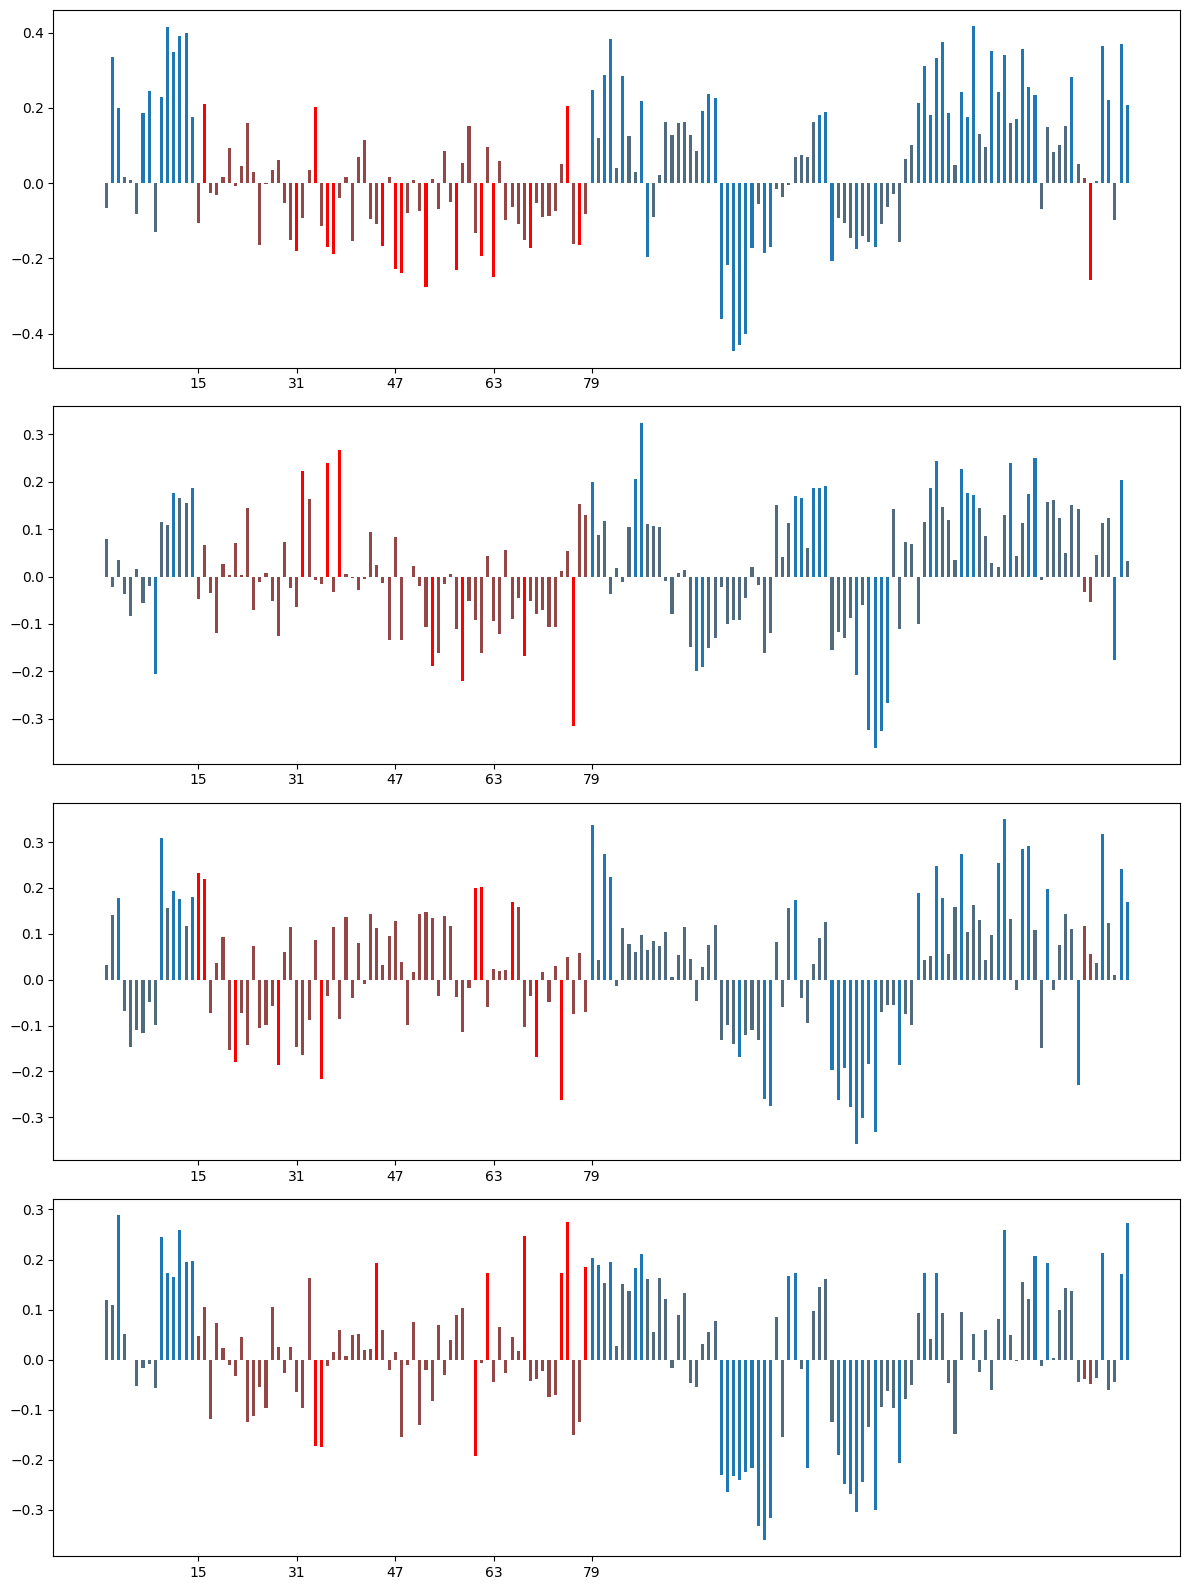

In [10]:

def key_token_correlation(attns, is_correct, corr_fn, ax=None, label=None):
  avg_attn = attns[..., -1, :].mean(dim=(1, 2))
  grouped_attn = group_vision_attns(attns[..., -1, 15:79], quadrant_width_n_tokens=4).reshape(*attns.shape[:-2], -1)
  avg_attn[..., 15:79] = grouped_attn.mean((1, 2))
  avg_attn = avg_attn.to(torch.float32)
  is_correct = is_correct.view(-1, 1)
  result = corr_fn(is_correct, avg_attn, axis=0)
  insig_idx = result.pvalue >= 0.1
  x_offset = np.arange(avg_attn.shape[-1])
  
  is_img_token = np.zeros_like(x_offset, dtype=bool)
  is_img_token[15:79] = True
  is_img_token[-7] = True
  is_img_token[-8] = True
  
  if ax is None:
    ax = plt
    
  ax.bar(x_offset[~is_img_token], result.statistic[~is_img_token], width=0.5, label=label if label else None)
  ax.bar(x_offset[is_img_token], result.statistic[is_img_token], color='red', width=0.5, label=label if label else None)
  gray_tinted = (0.4, 0.4, 0.4, 0.7)
  ax.bar(x_offset[insig_idx], result.statistic[insig_idx], 
          color=gray_tinted, width=0.5)
  ax.set_xticks(np.arange(15, 80, 16))

def plot_token_acc_correlation(attns, is_correct):
  fig, axes = plt.subplots(4, 1, figsize=(12, 16))

  attns = attns.reshape(-1, 4, *attns_0.shape[1:]).transpose(1, 0)
  is_correct = is_correct.reshape(-1, 4).transpose(1, 0)


  for i in range(4):
    key_token_correlation(attns[i], is_correct[i], corr_fn=pearsonr, ax=axes[i])

  fig.tight_layout()
  fig.show()

plot_token_acc_correlation(attns_0, is_correct_0)
plot_token_acc_correlation(attns_1, is_correct_1)
plot_token_acc_correlation(attns_2, is_correct_2)